### General Concept

1. Given a pdf file of a bank transaction with multiple pages, get png/jpg of each page.
2. With png/jpg, detect relevant texts (e.g. Tanggal, Keterangan, Mutasi)
3. Put detected text into a DataFrame to be converted into a CSV file that is seperated by semicolons ;

Current issue: 1st page is empty

Current solution: Explicitly define page number

### Import Dump

In [1]:
import cv2
import pandas as pd
import fitz
import matplotlib.pyplot as plt
import pytesseract
import warnings


warnings.simplefilter(action='ignore', category=FutureWarning)

### Scanning

First we convert the pdf into a png per page

In [7]:
pdf_name = "pajak.pdf"

doc = fitz.open(pdf_name)

for page in doc:
    pix = page.get_pixmap(dpi=600)
    name = pdf_name[:-4] + ".png"
    pix.save(name)

Use an OCR (optical character recognition) model for reading text

In [4]:
# define tesseract OCT model 
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

Read the images to be put into an Image object in cv2

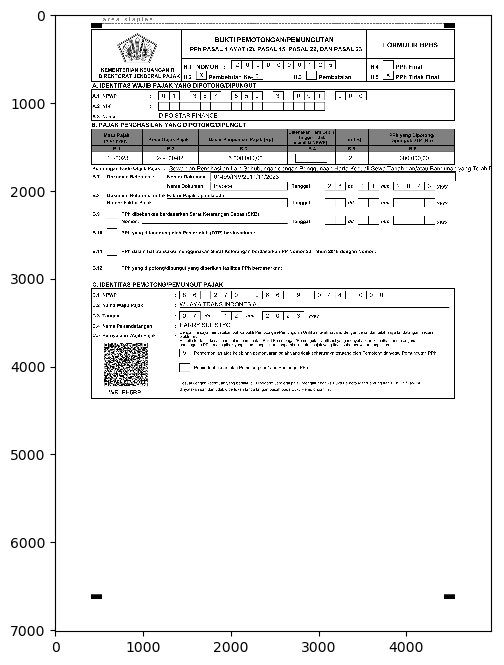

In [74]:
page_name = pdf_name[:-4] + ".png"

# read png
page = cv2.imread(page_name)

# show page image
plt.figure(figsize=(30,8))
plt.imshow(page, cmap="gray")

The important part of this file is below the row with "Tanggal, Keterangan, ...". So crop this part. Assume that the height ratio proportion of this bank statement to be stable. 

The height crop in this image should be around the 2050th pixel and the image is 7017 pixels high. So the ratio is 2050/7017 which is around 0.298. So crop at the 29.8% height of the image regardless of the image size.

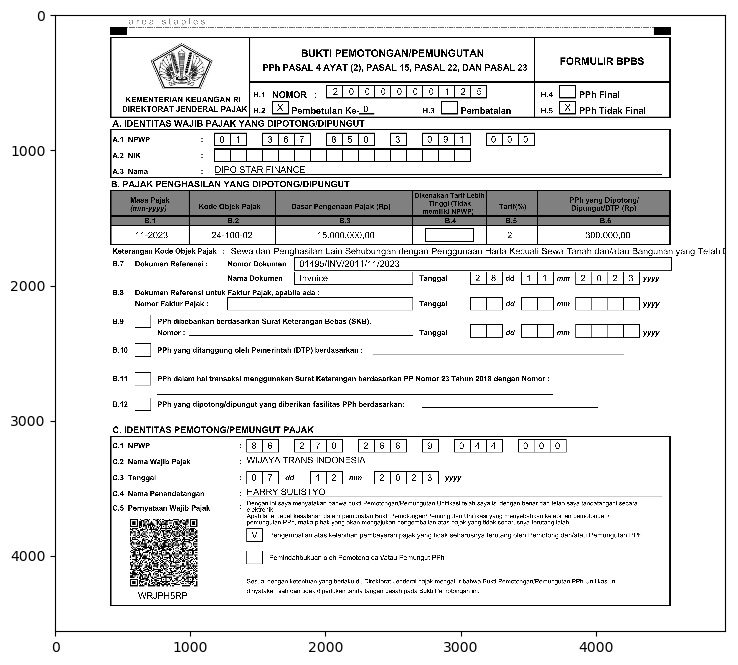

In [75]:
# get page height
page_height = page.shape[0]

# crop to only table
page = page[:int(page_height * 0.65), :]

plt.figure(figsize=(30,8))
plt.imshow(page, cmap="gray")

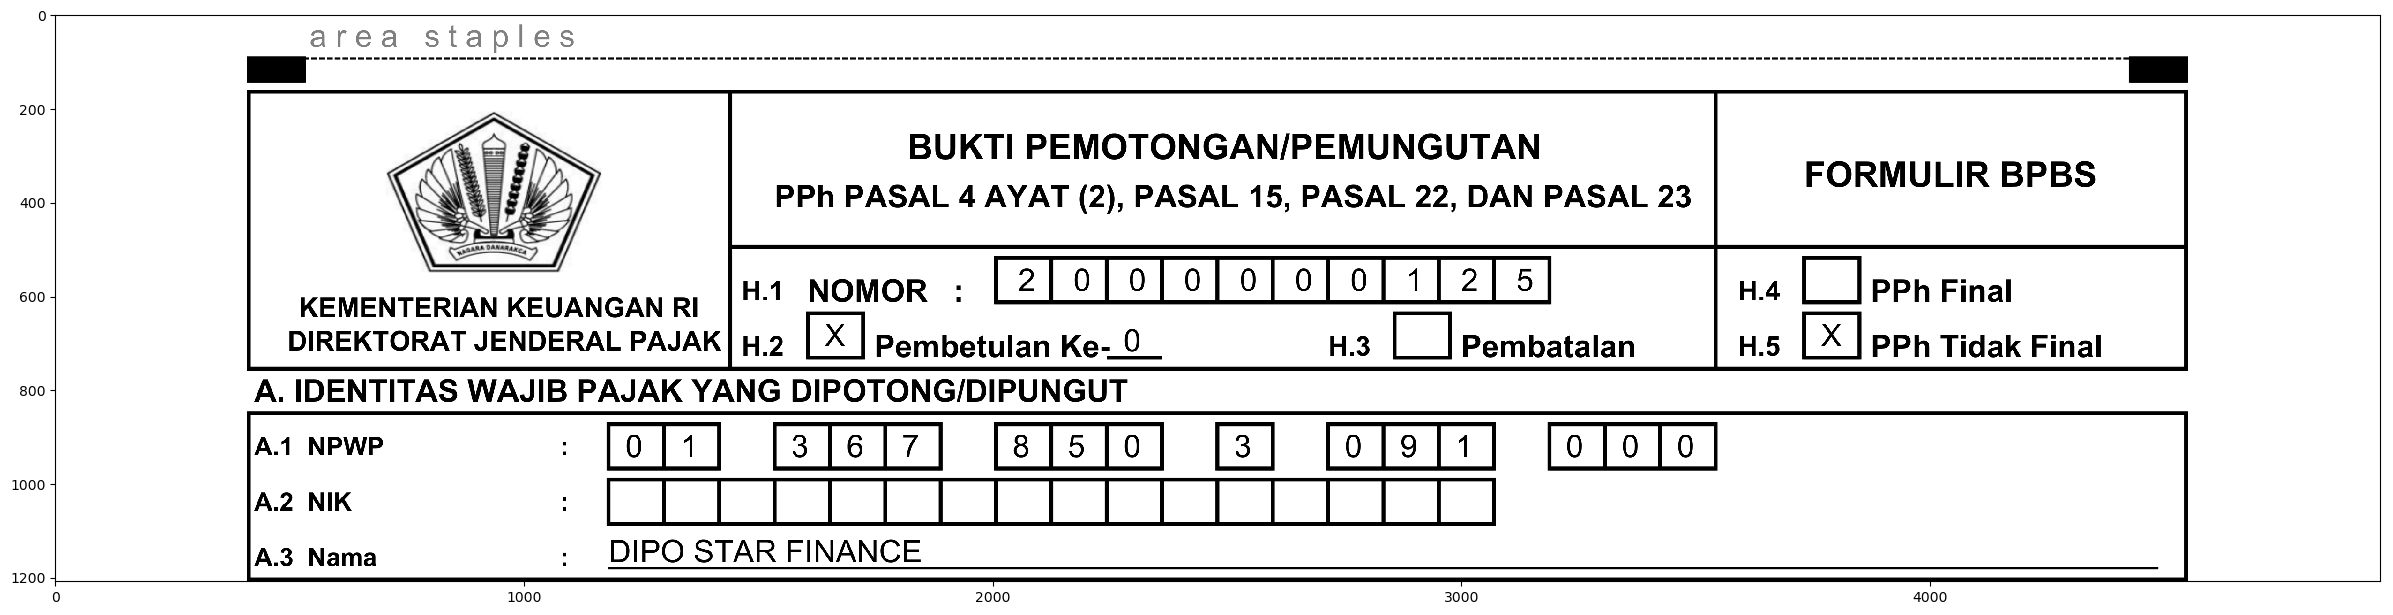

In [76]:
page_height = page.shape[0]

c1 = page[:int(page_height * 0.265), :]
c2 = page[int(page_height * 0.265):int(page_height * 0.66), :]
c3 = page[int(page_height * 0.66):, :]

plt.figure(figsize=(30, 8))
plt.imshow(c1, cmap="gray")

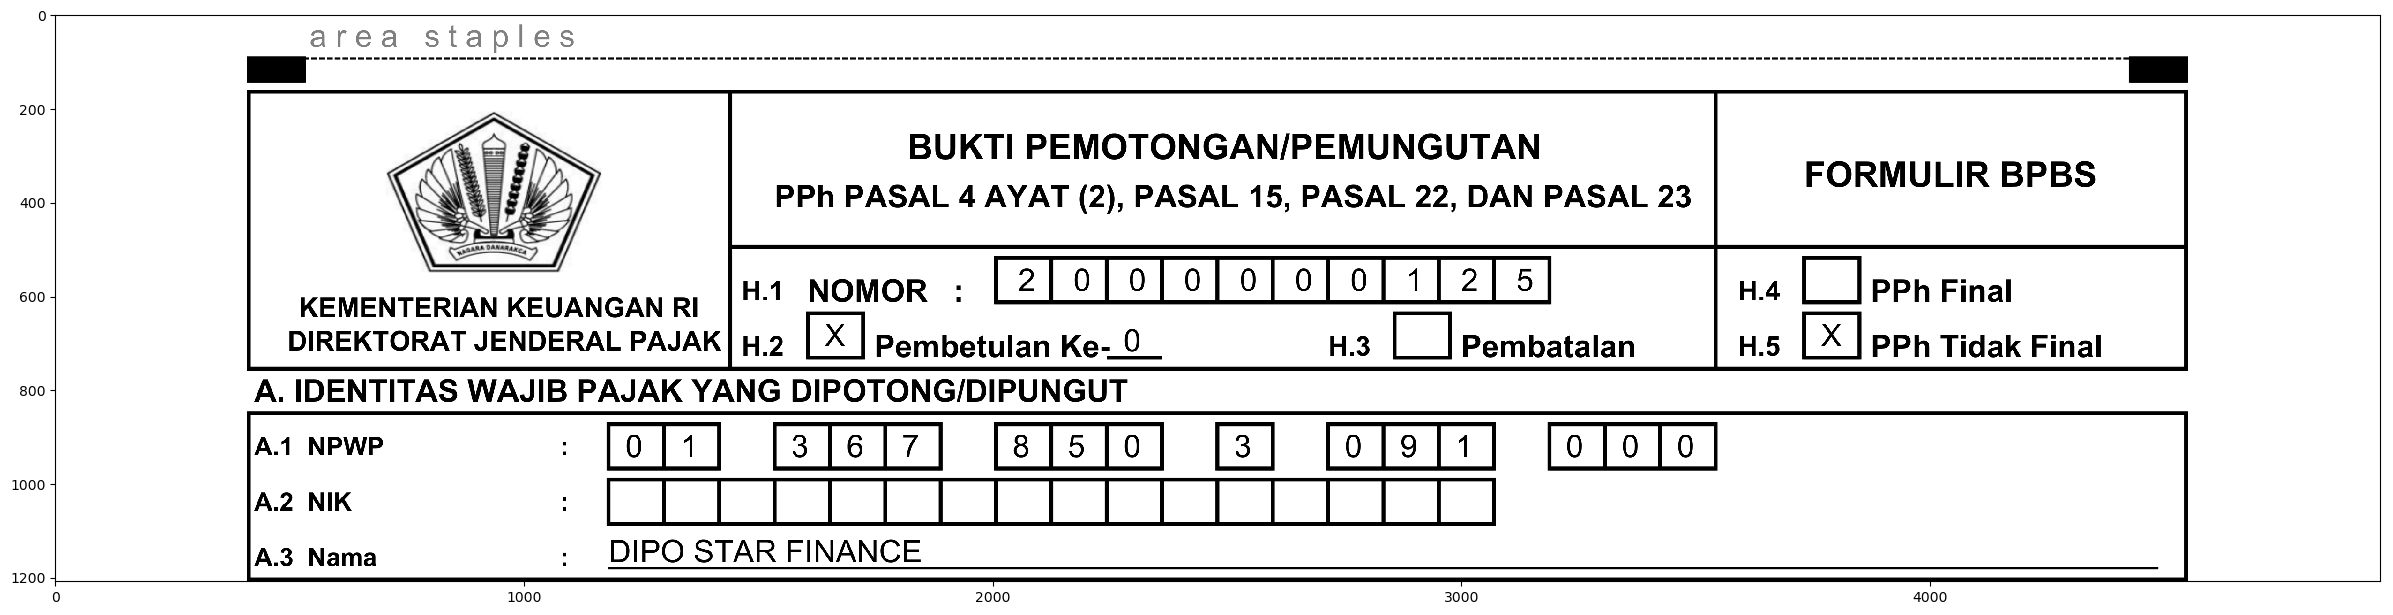

In [77]:
page_height = page.shape[0]

c1 = page[:int(page_height * 0.265), :]
c2 = page[int(page_height * 0.265):int(page_height * 0.66), :]
c3 = page[int(page_height * 0.66):, :]

plt.figure(figsize=(30, 8))
plt.imshow(c1, cmap="gray")

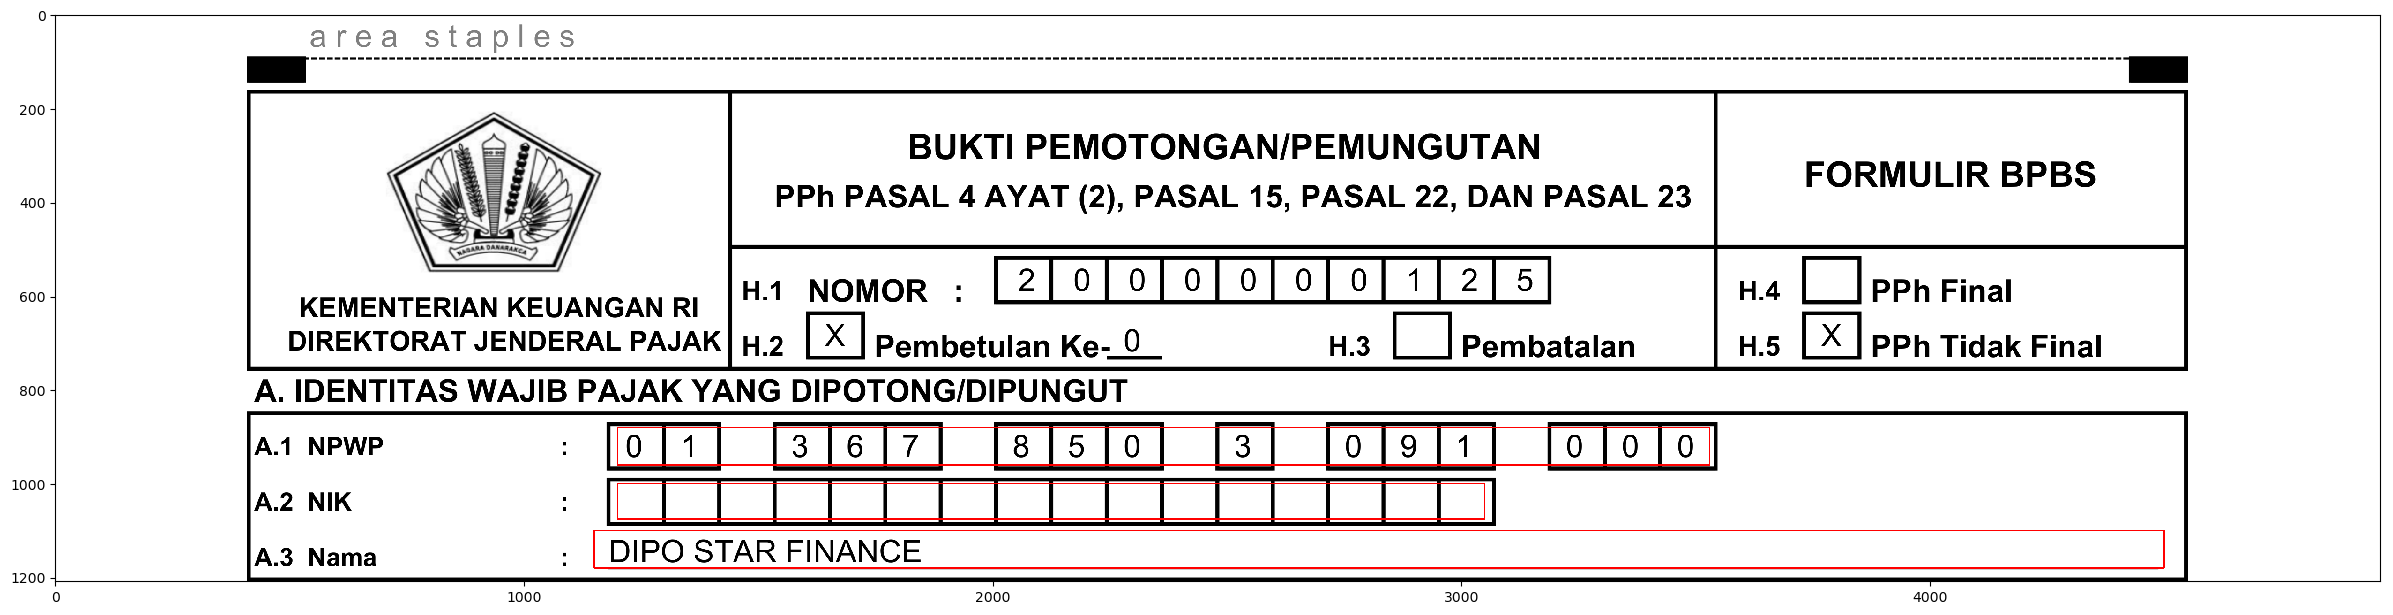

In [88]:
c1_copy = c1.copy()

# x1, x2, y1, y2
rois = [(1200, 3530, 880, 960),
        (1200, 3050, 1000, 1075),
        (1150, 4500, 1100, 1180)]

for r in rois:
    cv2.rectangle(c1_copy, (r[0], r[2]), (r[1], r[3]), (255, 0, 0), 2)

plt.figure(figsize=(30, 8))
plt.imshow(c1_copy)

In [93]:
crop = c1[rois[0][2]:rois[0][3],rois[0][0]:rois[0][1]]
crop = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
# _, crop = cv2.threshold(crop, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)

text = pytesseract.image_to_string(crop, config="--psm 13")
text

'Oli); IT3/6]7])] [8/5707] [3] JolT9oat1] Jotlofo\n'